# Importing Libraries

In [1]:
import torch

import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2

from collections import Counter

import shutil
import random

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, ConcatDataset

import torchvision.models as models
import timm 

import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.cuda.amp import autocast, GradScaler

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
train_dataset_path = 'Dataset/Train'
test_dataset_path = 'Dataset/Test'
train_augmented_dataset_path = 'Dataset/Augmented'

Combined training dataset has 9249 images.
Label counts in combined training dataset: Counter({'Normal': 1787, 'Blast': 1392, 'BacterialBlight': 1269, 'SheathBlight': 1201, 'BacterialLeafBlight': 1200, 'BacterialLeafStreak': 1200, 'BrownSpot': 1200})


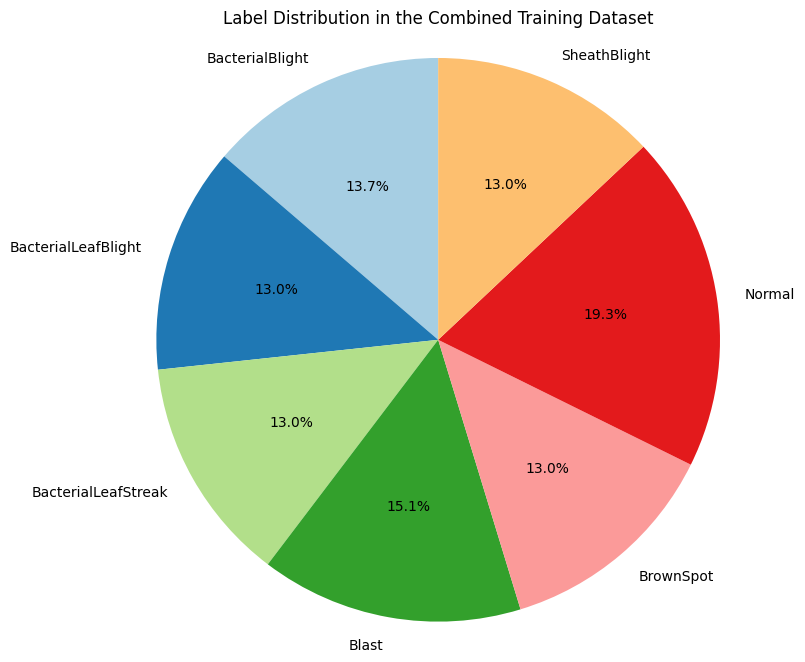

In [ ]:
# Define paths
train_augmented_path = 'Dataset/Augmented'
train_dataset_path = 'Dataset/Train'
test_dataset_path = 'Dataset/Test'

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

# Define transformations for validation data (test data)
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
])

# Load the original training dataset
train_dataset = datasets.ImageFolder(train_dataset_path, transform=train_transforms)

# Load the augmented dataset (if any)
augmented_dataset = datasets.ImageFolder(train_augmented_path, transform=train_transforms)

# Combine the original and augmented training datasets
combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])
print(f"Combined training dataset has {len(combined_train_dataset)} images.")

# Load the test dataset
test_dataset = datasets.ImageFolder(test_dataset_path, transform=test_transforms)

# Function to count the labels in the dataset
def count_labels(dataset):
    class_to_idx = dataset.datasets[0].class_to_idx if isinstance(dataset, ConcatDataset) else dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    label_count = Counter()

    # Count each label in the combined dataset
    for dataset_part in dataset.datasets if isinstance(dataset, ConcatDataset) else [dataset]:
        for _, label in dataset_part.samples:
            label_name = idx_to_class[label]
            label_count[label_name] += 1

    return label_count

# Count the labels in the combined training dataset
label_counts = count_labels(combined_train_dataset)
print(f"Label counts in combined training dataset: {label_counts}")

# Plotting pie chart of label distribution
def plot_pie_chart(label_counts):
    labels = label_counts.keys()
    sizes = label_counts.values()

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    plt.title('Label Distribution in the Combined Training Dataset')
    plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
    plt.show()

# Plot pie chart for label distribution
plot_pie_chart(label_counts)

# Training

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [5]:
# Initialize models
models_dict = {
    'SE-ResNet-50': timm.create_model('seresnet50', pretrained=True),
    'ResNeXt-50': timm.create_model('resnext50_32x4d', pretrained=True),
    'ResNet-50': models.resnet50(pretrained=True),
}

# Modify the final layer for each model to match the number of classes
num_classes = len(train_dataset.classes)
for model_name, model in models_dict.items():
    if hasattr(model, 'fc'):  # Check if the model has 'fc'
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier'):  # Check if the model has 'classifier'
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} does not have a known final layer.")

c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Define training parameters
batch_size = 32
num_workers = 8
max_epochs = 15
initial_lr = 0.001
momentum = 0.9

# Create data loaders
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Optimizer and scheduler
def get_optimizer_and_scheduler(model, warmup_epochs=2):
    # Stochastic Gradient Descent (SGD) optimizer with momentum
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum)

    # Warm-up scheduler (increases LR linearly for the first few epochs)
    def warmup_lambda(epoch):
        if epoch < warmup_epochs:
            return epoch / warmup_epochs
        else:
            return 1.0
    
    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
    
    # Cosine Annealing Scheduler (decays LR according to cosine function)
    cosine_scheduler = CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

    return optimizer, warmup_scheduler, cosine_scheduler

In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
# Function to train one epoch and calculate training accuracy
def train_one_epoch(model, train_loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize with mixed precision
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()  # Scale the loss for mixed precision
        scaler.step(optimizer)         # Unscales the gradients and calls optimizer.step()
        scaler.update()                # Updates the scaler for the next iteration

        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [10]:
# Function to evaluate the model
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [11]:
# Training loop for all models with mixed precision
def train_model(models_dict, model_name, train_loader, val_loader, num_epochs, device):
    if model_name not in models_dict:
        raise ValueError(f"Model {model_name} not found in models_dict.")
    
    print(f"Training {model_name}...")

    model = models_dict[model_name].to(device)
    optimizer, warmup_scheduler, cosine_scheduler = get_optimizer_and_scheduler(model)
    scaler = GradScaler()  # Initialize GradScaler for mixed precision

    best_accuracy = 0.0
    model_history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(num_epochs):
        # Warm-up phase for the first few epochs
        if epoch < 2:
            warmup_scheduler.step()

        # Train the model for one epoch with mixed precision
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        model_history['train_loss'].append(train_loss)
        model_history['train_accuracy'].append(train_accuracy)
        model_history['val_loss'].append(val_loss)
        model_history['val_accuracy'].append(val_accuracy)

        # Update learning rate with cosine annealing after warmup
        if epoch >= 2:
            cosine_scheduler.step()

        # Save the model if it achieves the best validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'Models/final_{model_name}.pth')

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return model_history


In [12]:
def plot_training_history(model_name, model_history):
    epochs = range(1, len(model_history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 4))

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model_history['train_loss'], label='Training Loss')
    plt.plot(epochs, model_history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model_history['val_accuracy'], label='Validation Accuracy', color='green')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_plot.png')  # Save the plot as an image file
    plt.show()

In [13]:
model_1 = 'SE-ResNet-50'

In [14]:
history_model_1 = train_model(models_dict, model_1, train_loader, test_loader, num_epochs=20, device=device)

Training SE-ResNet-50...


C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_2400\4224793097.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for mixed precision
c:\Users\Pdogg Windows10\Desktop\Semester 7\Major Project\Project\majorproject\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_2400\748526415.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` 

Epoch [1/20] - Train Loss: 1.8503, Train Accuracy: 0.2706, Val Loss: 1.7636, Val Accuracy: 0.4649
Epoch [2/20] - Train Loss: 1.6005, Train Accuracy: 0.5195, Val Loss: 1.4418, Val Accuracy: 0.5698
Epoch [3/20] - Train Loss: 1.3308, Train Accuracy: 0.6044, Val Loss: 1.2027, Val Accuracy: 0.6430
Epoch [4/20] - Train Loss: 1.1174, Train Accuracy: 0.6582, Val Loss: 1.0188, Val Accuracy: 0.6763
Epoch [5/20] - Train Loss: 0.9546, Train Accuracy: 0.6970, Val Loss: 0.8420, Val Accuracy: 0.7101
Epoch [6/20] - Train Loss: 0.8403, Train Accuracy: 0.7202, Val Loss: 0.7440, Val Accuracy: 0.7608
Epoch [7/20] - Train Loss: 0.7415, Train Accuracy: 0.7506, Val Loss: 0.6557, Val Accuracy: 0.7708
Epoch [8/20] - Train Loss: 0.6693, Train Accuracy: 0.7750, Val Loss: 0.6114, Val Accuracy: 0.7747
Epoch [9/20] - Train Loss: 0.6118, Train Accuracy: 0.7957, Val Loss: 0.5579, Val Accuracy: 0.8107
Epoch [10/20] - Train Loss: 0.5714, Train Accuracy: 0.8059, Val Loss: 0.4893, Val Accuracy: 0.8336
Epoch [11/20] - Tra

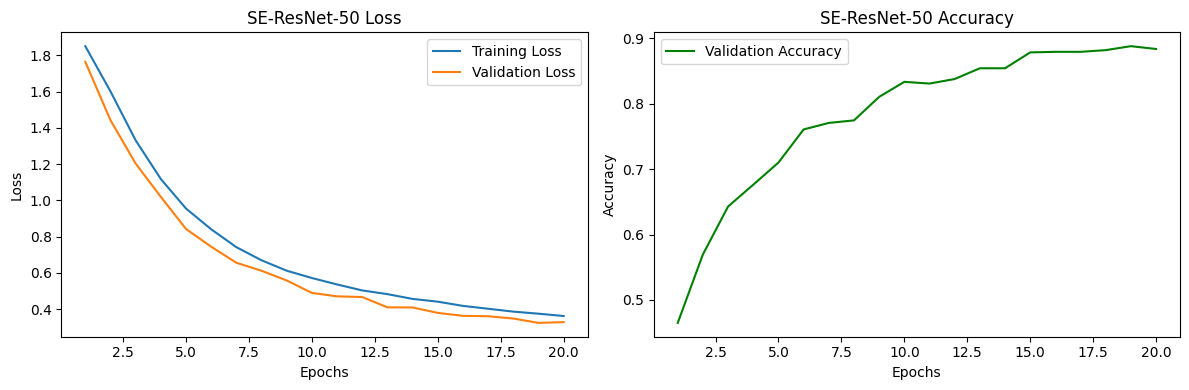

In [15]:
plot_training_history(model_1, history_model_1)

In [16]:
model_2 = 'ResNeXt-50'

In [18]:
history_model_2 = train_model(models_dict, model_2, train_loader, test_loader, num_epochs=15, device=device)

Training ResNeXt-50...


C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_2400\4224793097.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for mixed precision
C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_2400\748526415.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/15] - Train Loss: 1.7507, Train Accuracy: 0.3848, Val Loss: 1.6801, Val Accuracy: 0.4775
Epoch [2/15] - Train Loss: 1.4681, Train Accuracy: 0.5594, Val Loss: 1.2817, Val Accuracy: 0.6209
Epoch [3/15] - Train Loss: 1.1012, Train Accuracy: 0.6577, Val Loss: 0.9658, Val Accuracy: 0.7058
Epoch [4/15] - Train Loss: 0.8543, Train Accuracy: 0.7243, Val Loss: 0.7455, Val Accuracy: 0.7565
Epoch [5/15] - Train Loss: 0.7000, Train Accuracy: 0.7699, Val Loss: 0.6511, Val Accuracy: 0.7925
Epoch [6/15] - Train Loss: 0.5996, Train Accuracy: 0.8010, Val Loss: 0.6779, Val Accuracy: 0.7556
Epoch [7/15] - Train Loss: 0.5141, Train Accuracy: 0.8287, Val Loss: 0.4454, Val Accuracy: 0.8644
Epoch [8/15] - Train Loss: 0.4441, Train Accuracy: 0.8572, Val Loss: 0.3842, Val Accuracy: 0.8687
Epoch [9/15] - Train Loss: 0.3942, Train Accuracy: 0.8774, Val Loss: 0.3520, Val Accuracy: 0.8873
Epoch [10/15] - Train Loss: 0.3520, Train Accuracy: 0.8907, Val Loss: 0.3487, Val Accuracy: 0.8873
Epoch [11/15] - Tra

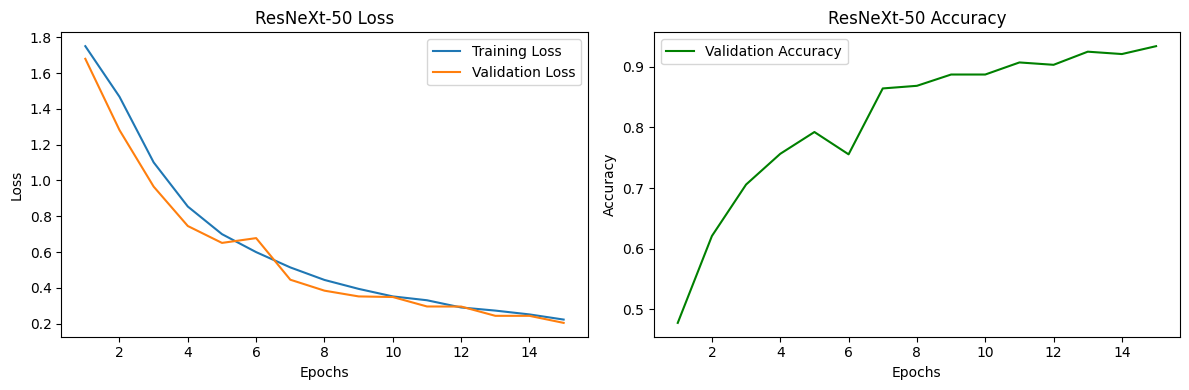

In [19]:
plot_training_history(model_2, history_model_2)

In [20]:
model_3 = 'ResNet-50'

In [21]:
history_model_3 = train_model(models_dict, model_3, train_loader, test_loader, num_epochs=10, device=device)

Training ResNet-50...


C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_2400\4224793097.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Initialize GradScaler for mixed precision
C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_2400\748526415.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10] - Train Loss: 0.9296, Train Accuracy: 0.7009, Val Loss: 0.4240, Val Accuracy: 0.8657
Epoch [2/10] - Train Loss: 0.3227, Train Accuracy: 0.8956, Val Loss: 0.1693, Val Accuracy: 0.9471
Epoch [3/10] - Train Loss: 0.1439, Train Accuracy: 0.9561, Val Loss: 0.1065, Val Accuracy: 0.9653
Epoch [4/10] - Train Loss: 0.0936, Train Accuracy: 0.9747, Val Loss: 0.0867, Val Accuracy: 0.9744
Epoch [5/10] - Train Loss: 0.0606, Train Accuracy: 0.9829, Val Loss: 0.0651, Val Accuracy: 0.9801
Epoch [6/10] - Train Loss: 0.0523, Train Accuracy: 0.9872, Val Loss: 0.0715, Val Accuracy: 0.9801
Epoch [7/10] - Train Loss: 0.0425, Train Accuracy: 0.9886, Val Loss: 0.0526, Val Accuracy: 0.9840
Epoch [8/10] - Train Loss: 0.0380, Train Accuracy: 0.9917, Val Loss: 0.0418, Val Accuracy: 0.9870
Epoch [9/10] - Train Loss: 0.0267, Train Accuracy: 0.9947, Val Loss: 0.0378, Val Accuracy: 0.9896
Epoch [10/10] - Train Loss: 0.0204, Train Accuracy: 0.9952, Val Loss: 0.0375, Val Accuracy: 0.9887


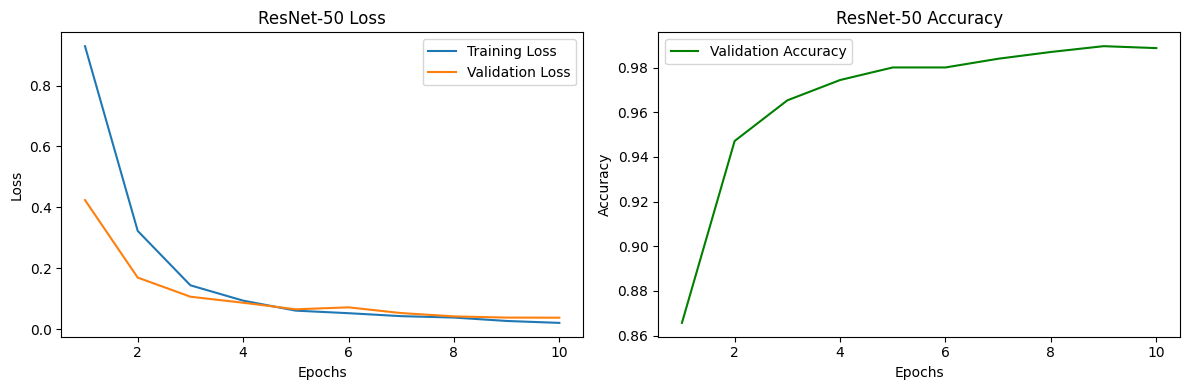

In [22]:
plot_training_history(model_3, history_model_3)